Наступило лето, пора отпусков и путешествий! Самое время планировать, куда отправиться и как спланировать свой маршрут, а также не забыть проверить погоду и выбрать подходящие даты, чтобы не испортить себе отдых. Но так ли на самом деле важна погода в путешествиях? Или новые впечатления и смена обстановки заслоняют любые природные напасти? Может ли плохая погода действительно испортить отдых? В этом маленьком исследовании я предлагаю это проверить :)

Возьмем туристический город, который славится своей плохой погодой - например, Лондон - и сравним отзывы туристов с погодой в дату их приезда. Исследовав данные и применив модели машинного обучения, предсказывающие рейтинг отзыва, у нас получится ответить на вопрос, насколько сильно плохая погода портит впечатление от отдыха, и стоит ли ориентироваться на нее при планировании путешествия. Но стоит учитывать, что Лондон, все же, город для активного отдыха, где важны историческое наследие и культурная программа, поэтому в качестве маленького сравнения попробуем посмотреть так же на отзывы о пляжных курортах (я взяла пляжи Таиланда и Доминиканы, так как они славятся своей дождливостью).

Моя нулевая гипотеза состоит в том, что погода на впечатления о путешествии не влияет. Давайте это проверим! 

Импортируем необходимые библиотеки

In [265]:
# общие библиотеки

import numpy as np
import pandas as pd
import wget

# библиотека для использования SQL

import duckdb

# библиотеки для веб-скрэппинга

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time

# библиотеки для использования API запросов

import openmeteo_requests
import requests_cache
import requests
from requests.structures import CaseInsensitiveDict
from retry_requests import retry

# библиотеки для работы с геоданными и картами

import geopandas as gpd
import mapclassify
import folium

# библиотеки для визуализации

import networkx as nx
from pywaffle import Waffle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# библиотеки для обработки текстов

import re
import nltk
from nltk import tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import pymorphy2
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from navec import Navec

!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

nltk.download("stopwords")
stopwords = stopwords.words("russian")

# ML

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


--2024-06-09 20:03:09--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: 'navec_hudlit_v1_12B_500K_300d_100q.tar.1'

navec_hudlit_v1_12B 100%[===================>]  50.56M  9.15MB/s    in 5.8s    

2024-06-09 20:03:15 (8.77 MB/s) - 'navec_hudlit_v1_12B_500K_300d_100q.tar.1' saved [53012480/53012480]



[nltk_data] Downloading package stopwords to /Users/alina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Получение данных: API и вэб-скрэппинг при помощи Selenium

Возьмем исторические данные о ежедневной погоде в Лондоне за последние 8 лет, на пляже Баваро (Доминиканская Республика)
и пляже Пхра Нанг (Таиланд) за последние 3 года. 

Выгрузим такие признаки как код погоды (тип погоды сочетающейся с осадками и влажностью), максимальную температуру, минимальную температуру,
среднюю температуру, количество дождя, снега, скорость ветра и уровень солнечного излучения.

In [2]:
# Weather Api
# ! используется обращение к документированному API 

In [3]:
# задаем ссылку архива для обращения API, параметры для локаций (координаты) и признаки

cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


url = "https://archive-api.open-meteo.com/v1/archive"

params_london = {
	"latitude": 51.5085,
	"longitude": -0.1257,
	"start_date": "2016-01-01",
	"end_date": "2024-03-01",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "Europe/London"
}

params_bavaro = {
	"latitude": 18.666,
	"longitude": -68.3968,
	"start_date": "2020-01-01",
	"end_date": "2023-01-01",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "America/New_York"
}

params_phra_nang = {
	"latitude": 13.8703,
	"longitude": 100.4762,
	"start_date": "2018-01-01",
	"end_date": "2021-01-01",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "rain_sum", "snowfall_sum", "wind_speed_10m_max", "shortwave_radiation_sum"],
	"timezone": "Asia/Bangkok"
}


In [4]:
def get_weather_data(url, params):

    """
    Функция обращается к API openmeteo, извлекает исторические данные о погоде в локации, заданной раннее,
    создает датафрейм с параметрами за указанный период, возвращает датафрейм с данными о погоде.
    """

    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    daily = response.Daily()
    
    data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left")}
    
    data["weather_code"] = daily.Variables(0).ValuesAsNumpy()
    data["max_temperature"] = daily.Variables(1).ValuesAsNumpy()
    data["min_temperature"] = daily.Variables(2).ValuesAsNumpy()
    data["mean_temperature"] = daily.Variables(3).ValuesAsNumpy()
    data["sum_rain"] = daily.Variables(4).ValuesAsNumpy()
    data["sum_snowfall"] = daily.Variables(5).ValuesAsNumpy()
    data["max_wind_speed"] = daily.Variables(6).ValuesAsNumpy()
    data["sum_shortwave_radiation"] = daily.Variables(7).ValuesAsNumpy()
    dataframe = pd.DataFrame(data = data)
    return dataframe

In [5]:
# получаем все необходимые признаки в формате датафреймов

london_weather = get_weather_data(url, params_london)
bavaro_weather = get_weather_data(url, params_bavaro)
phra_nang_weather = get_weather_data(url, params_phra_nang)

In [6]:
london_weather

date  weather_code  max_temperature  \
0    2015-12-31 23:00:00+00:00          51.0         7.800000   
1    2016-01-01 23:00:00+00:00          55.0        10.050000   
2    2016-01-02 23:00:00+00:00          63.0         9.500000   
3    2016-01-03 23:00:00+00:00          51.0         9.300000   
4    2016-01-04 23:00:00+00:00          53.0         9.450000   
...                        ...           ...              ...   
2978 2024-02-25 23:00:00+00:00          53.0         8.606501   
2979 2024-02-26 23:00:00+00:00          53.0         7.556500   
2980 2024-02-27 23:00:00+00:00          51.0        10.806500   
2981 2024-02-28 23:00:00+00:00          61.0        10.856501   
2982 2024-02-29 23:00:00+00:00          71.0         8.356501   

      min_temperature  mean_temperature   sum_rain  sum_snowfall  \
0             -0.4000          4.518750   1.100000          0.00   
1              7.5500          9.185416   5.699999          0.00   
2              5.5000          7.670833  11.300001          0.00   
3              5.3000          6.862500   0.900000          0.00   
4              3.5500          6.847918   0.700000          0.00   
...               ...               ...        ...           ...   
2978           3.3565          6.208583   1.400000          0.00   
2979           1.8065          4.637750   0.500000          0.00   
2980           5.5065          8.379416   1.300000          0.00   
2981           5.9065          9.316916   8.300000          0.00   
2982           3.1565          5.210667   6.500000          0.07   

      max_wind_speed  sum_shortwave_radiation  
0          25.864943                     2.13  
1          28.165257                     0.63  
2          31.106167                     0.47  
3          17.068707                     2.81  
4          19.083395                     2.92  
...              ...                      ...  
2978       43.672913                     7.12  
2979       15.038350                     5.19  
2980       25.071098                     3.53  
2981       26.099379                     2.04  
2982       34.942265                     8.22  

[2983 rows x 9 columns]

In [7]:
bavaro_weather

date  weather_code  max_temperature  \
0    2020-01-01 04:00:00+00:00          53.0        27.186499   
1    2020-01-02 04:00:00+00:00           1.0        27.886499   
2    2020-01-03 04:00:00+00:00          53.0        26.336500   
3    2020-01-04 04:00:00+00:00          51.0        27.486500   
4    2020-01-05 04:00:00+00:00          51.0        27.286499   
...                        ...           ...              ...   
1092 2022-12-28 04:00:00+00:00          53.0        26.936499   
1093 2022-12-29 04:00:00+00:00          51.0        27.836500   
1094 2022-12-30 04:00:00+00:00          55.0        27.186499   
1095 2022-12-31 04:00:00+00:00          53.0        27.236500   
1096 2023-01-01 04:00:00+00:00          53.0        27.336500   

      min_temperature  mean_temperature  sum_rain  sum_snowfall  \
0           24.336500         25.738581       3.5           0.0   
1           24.736500         25.919832       0.0           0.0   
2           24.436499         25.230247       5.1           0.0   
3           24.286499         25.528166       0.6           0.0   
4           23.336500         24.963585       2.0           0.0   
...               ...               ...       ...           ...   
1092        21.836500         24.726084       1.0           0.0   
1093        24.436499         25.692747       0.6           0.0   
1094        23.136499         25.076082       5.4           0.0   
1095        22.736500         25.001083       2.8           0.0   
1096        22.586500         24.551085       1.9           0.0   

      max_wind_speed  sum_shortwave_radiation  
0          12.722830                13.000000  
1          16.548256                17.500000  
2          22.039528                10.750000  
3          19.652176                16.750000  
4          17.148247                15.150000  
...              ...                      ...  
1092       15.192682                15.490000  
1093       20.608231                17.650000  
1094       20.326454                16.309999  
1095       17.654688                17.270000  
1096       15.379206                15.520000  

[1097 rows x 9 columns]

Используем Selenium для скрэппинга TripAdvisor: 10 страниц для 10 достопримечательностей Лондона, а также по 10 страниц для двух самых дождливых пляжей. 

Для того, чтобы удостовериться в правильности написанно кода, можно запустить ячейку только для одной достопримечательности, потому что после этого TripAdvisor начнет блокировать ip адрес, защищаясь от скрэппинга. Для проверки скрэппинга всех данных следует использовать VPN, меняя локацию после скрэппинга каждой достопримечательности.

Чтобы не приходилось каждый раз перезапускать ячейки со скрэппингом, после первого скрэппинга всех страниц я сохранила данные в csv формате (можно проверить, что они отличаются от формата JSON, автоматически сохраняемых TripAdvisor, и формата, который получается на выходе после готовых API библиотек, то есть эти данные я проскрэпила сама в кастомном формате).

Имена html-классов и css селектор кнопки перехода на следующую страницу я извлекла вручную, просмотрев страницы TripAdvisor:

DATE CLASS: 'RpeCd'


REVIEW CLASS: 'yCeTE'

CSS SELECTOR: '#tab-data-qa-reviews-0 > div > div.LbPSX > div > div:nth-child(11) > div:nth-child(2) > div > div.OvVFl.j > div > div > a'

Рейтинги я собирала по html-тегу "title"



In [8]:
# загрузка раннее проскрэпленных данных 

bigben = pd.read_csv('/Users/alina/Desktop/DS_project/bigben.csv')
trafalgar_square = pd.read_csv('/Users/alina/Desktop/DS_project/trafalgar_square.csv')
london_eye = pd.read_csv('/Users/alina/Desktop/DS_project/london_eye.csv')
tower_bridge = pd.read_csv('/Users/alina/Desktop/DS_project/tower_bridge.csv')
buckingham_palace = pd.read_csv('/Users/alina/Desktop/DS_project/buckingham_palace.csv')
saint_james = pd.read_csv('/Users/alina/Desktop/DS_project/saint_james.csv')
shard = pd.read_csv('/Users/alina/Desktop/DS_project/shard.csv')
hyde_park = pd.read_csv('/Users/alina/Desktop/DS_project/hyde_park.csv')
westminster_abbey = pd.read_csv('/Users/alina/Desktop/DS_project/westminster_abbey.csv')
greenwich = pd.read_csv('/Users/alina/Desktop/DS_project/greenwich.csv')


bavaro = pd.read_csv('/Users/alina/Desktop/DS_project/bavaro.csv')
phra_nang = pd.read_csv('/Users/alina/Desktop/DS_project/phra_nang.csv')

# при сохранении в csv формат, а потом выгрузке данных снова в формат датафрейма, колонка индексов дублируется, здесь убираем ее

bigben = bigben.iloc[: , 1:]
trafalgar_square = trafalgar_square.iloc[: , 1:]
london_eye = london_eye.iloc[:, 1:]
tower_bridge = tower_bridge.iloc[:, 1:]
buckingham_palace = buckingham_palace.iloc[:, 1:]
saint_james = saint_james.iloc[:, 1:]
shard = shard.iloc[:, 1:]
hyde_park = hyde_park.iloc[:, 1:]
westminster_abbey = westminster_abbey.iloc[:, 1:]
greenwich = greenwich.iloc[:, 1:]

bavaro = bavaro.iloc[:, 1:]
phra_nang = phra_nang.iloc[:, 1:]

In [9]:
bigben

date            rating  \
0                            июль 2021 г.  5,0 из 5 кружков   
1                март 2020 г. • Для двоих  1,0 из 5 кружков   
2   янв. 2020 г. • Путешествие в одиночку  5,0 из 5 кружков   
3                янв. 2020 г. • Для двоих  5,0 из 5 кружков   
4                           сент. 2019 г.  4,0 из 5 кружков   
..                                    ...               ...   
95                           янв. 2019 г.  3,0 из 5 кружков   
96  дек. 2018 г. • Путешествие в одиночку  2,0 из 5 кружков   
97                           авг. 2018 г.  5,0 из 5 кружков   
98          окт. 2018 г. • Семейный отдых  5,0 из 5 кружков   
99               окт. 2018 г. • Для двоих  5,0 из 5 кружков   

                                        title  \
0            Одни из самых больших часов мира   
1                                Нет Биг Бена   
2                                    Биг-Бен    
3                    Печально что на ремонте.   
4   Поездра в Лондон из Саутгемптона в круизе   
..                                        ...   
95                            Ещё на ремонте    
96                             Разочарование!   
97                              Учебник наяву   
98                 Для галочки стоит побывать   
99                                  Ремонт...   

                                               review  
0   Биг-Бен или Часовая башня Вестминстерского дво...  
1   Вышли на остановке, иду к Биг Бену  а его там ...  
2   Биг Бен встретил 2020 год в строительных лесах...  
3   Прибыли в Лондон и сразу пошли гулять.Через ча...  
4   Добрались до Лондона на электричке из порта Са...  
..                                                ...  
95  Помимо «Биг Бена» много других исторических зд...  
96  Если вы никогда не были в Лондоне, то конечно ...  
97  Все мы в детстве учили английский в школе по о...  
98  Он окутан строительными леса и виден только ци...  
99  Поставлю пять автоматом, хотя самого Биг Бена ...  

[100 rows x 4 columns]

In [ ]:
# Скрэппинг
# ! используется продвинутый вэб-скрэппинг при помощи Selenium

In [289]:
# открываем драйвер (он уже предзагружен, если мы используем Сафари), задаем ссылки нужных страниц TripAdvisor 

driver = webdriver.Safari()

url_bigben = "https://www.tripadvisor.ru/Attraction_Review-g186338-d211709-Reviews-Big_Ben-London_England.html"
url_tower_bridge = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d187552-Reviews-Tower_Bridge-London_England.html'
url_saint_james = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d188126-Reviews-St_James_s_Park-London_England.html'
url_buckingham_palace = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d187549-Reviews-Buckingham_Palace-London_England.html'
url_london_eye = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d553603-Reviews-London_Eye-London_England.html'
url_shard = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d3539289-Reviews-The_View_from_The_Shard-London_England.html'
url_hyde_park = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d189030-Reviews-Hyde_Park-London_England.html'
url_greenwich = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d187601-Reviews-Greenwich-London_England.html'
url_trafalgar_square = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d188964-Reviews-Trafalgar_Square-London_England.html'
url_westminster_abbey = 'https://www.tripadvisor.ru/Attraction_Review-g186338-d189032-Reviews-Westminster_Abbey-London_England.html'

url_bavaro = 'https://www.tripadvisor.ru/Attraction_Review-g3176298-d215733-Reviews-Bavaro_Beach-Bavaro_Punta_Cana_La_Altagracia_Province_Dominican_Republic.html'
url_phra_nang = 'https://www.tripadvisor.ru/Attraction_Review-g1507054-d1426253-Reviews-PhraNang_Cave_Beach-Ao_Nang_Krabi_Town_Krabi_Province.html'

In [10]:
def get_reviews_tripadvisor(driver, url):

    """
    Функция заходит на страницу достопримечательности по ссылке, собирает по классам и тегу информацию о дате отзыва,
    названии отзыва, тексте отзыва, поставленном рейтинге с 10 страниц, сохраняет и возвращает в виде датафрейма. 
    """
    # создание датафрейма для хранения
    
    data = pd.DataFrame(columns = ['date', 'rating', 'title', 'review'])

    # драйвер заходит на страницу
    
    driver.get(url)

    # выжидаем некоторое время прежде чем страница загрузится

    time.sleep(5)

    # скрэпим 10 страниц
    
    for i in range(10):

        data_i = pd.DataFrame(columns = ['date', 'rating', 'title', 'review'])

        # dates

        date_container =  driver.find_elements(By.CLASS_NAME, 'RpeCd')
        date = [item.text for item in date_container]
        data_i['date'] = date
        
        # rating

        rating_container = driver.find_elements(By.TAG_NAME, "title")

        rating = [item.text for item in rating_container]
        rating = list(filter(None, rating))
        rating = [item for item in rating[2:] if item[0].isdigit()]
        
        data_i['rating'] = rating
        
        # reviews
        
        review_container = driver.find_elements(By.CLASS_NAME, 'yCeTE')
        
        title = [item.text for item in review_container[::2]]
        review = [item.text for item in review_container[1::2]]
        
        data_i['title'] = title
        data_i['review'] = review

        data = pd.concat([data, data_i])

        #  переходим на следующую страницу

        driver.find_element(By.CSS_SELECTOR, '#tab-data-qa-reviews-0 > div > div.LbPSX > div > div:nth-child(11) > div:nth-child(2) > div > div.OvVFl.j > div > div > a').send_keys(Keys.ENTER)

        # ждем пока она прогузится

        time.sleep(5)
        
    return data
    

Далее в каждой отдельной ячейке код для скрэпинга страницы достопримечательности или пляжа (чтобы было удобно отдельно их запускать и отслеживать блокировку TripAdvisor)

In [ ]:
bigben = get_reviews_tripadvisor(driver, url_bigben)

In [ ]:
tower_bridge = get_reviews_tripadvisor(driver, url_tower_bridge)

In [ ]:
saint_james = get_reviews_tripadvisor(driver, url_saint_james)

In [ ]:
buckingham_palace = get_reviews_tripadvisor(driver, url_buckingham_palace)

In [ ]:
london_eye = get_reviews_tripadvisor(driver, url_london_eye)

In [ ]:
shard = get_reviews_tripadvisor(driver, url_shard)

In [ ]:
hyde_park = get_reviews_tripadvisor(driver, url_hyde_park)

In [ ]:
greenwich = get_reviews_tripadvisor(driver, url_greenwich)

In [ ]:
trafalgar_square = get_reviews_tripadvisor(driver, url_trafalgar_square)

In [ ]:
westminster_abbey = get_reviews_tripadvisor(driver, url_westminster_abbey)

In [302]:

bavaro = get_reviews_tripadvisor(driver, url_bavaro)

In [ ]:

phra_nang = get_reviews_tripadvisor(driver, url_phra_nang)

In [ ]:
# закрываем сессию использования драйвера

driver.quit()

In [303]:
bavaro

date            rating  \
0                 май 2022 г.  5,0 из 5 кружков   
1   апр. 2022 г. • С друзьями  5,0 из 5 кружков   
2                март 2022 г.  5,0 из 5 кружков   
3               февр. 2022 г.  4,0 из 5 кружков   
4                янв. 2022 г.  3,0 из 5 кружков   
..                        ...               ...   
5                окт. 2021 г.  5,0 из 5 кружков   
6               нояб. 2021 г.  5,0 из 5 кружков   
7               сент. 2021 г.  5,0 из 5 кружков   
8               нояб. 2021 г.  5,0 из 5 кружков   
9                окт. 2021 г.  5,0 из 5 кружков   

                                   title  \
0            Потрясающе живописный пляж!   
1                         Шикарный пляж!   
2                                 Отпуск   
3                         Много водослей   
4                       Неухоженный пляж   
..                                   ...   
5                            Лучший пляж   
6   Отличный пляж с почти белым песочком   
7                            Пляж Баваро   
8                      Великолепный пляж   
9                          Пляжный отдых   

                                               review  
0   В широком смысле пляж Баваро включает в себя к...  
1   Главный пляж, на котором расположены все основ...  
2   Чистый океан, есть рыба, плавали с черепахой.Ч...  
3   Мелкий песок, хороший заход, но много водоросл...  
4   Сам по себе пляж очень неплохой. Красивые фото...  
..                                                ...  
5   Чистейший, пологий и плавный заход в океан , п...  
6   11 дней жили в одном из отелей на пляже Баваро...  
7   Шикарный пляж,приглашаем всех,красивейшие виды...  
8   Пляж идеален для семей с детьми, белый песок, ...  
9   Красивый, широкий пляж с белым песком, который...  

[100 rows x 4 columns]

In [281]:
# блок сохранения поскрэпленных страниц

buckingham_palace.to_csv('/Users/alina/Desktop/DS_project/buckingham_palace.csv', encoding='utf-8')
saint_james.to_csv('/Users/alina/Desktop/DS_project/saint_james.csv', encoding='utf-8')
london_eye.to_csv('/Users/alina/Desktop/DS_project/london_eye.csv', encoding='utf-8')
tower_bridge.to_csv('/Users/alina/Desktop/DS_project/tower_bridge.csv', encoding='utf-8')
shard.to_csv('/Users/alina/Desktop/DS_project/shard.csv', encoding='utf-8')
bigben.to_csv('/Users/alina/Desktop/DS_project/bigben.csv', encoding='utf-8')
trafalgar_square.to_csv('/Users/alina/Desktop/DS_project/trafalgar_square.csv', encoding='utf-8')
hyde_park.to_csv('/Users/alina/Desktop/DS_project/hyde_park.csv', encoding='utf-8')
greenwich.to_csv('/Users/alina/Desktop/DS_project/greenwich.csv', encoding='utf-8')
westminster_abbey.to_csv('/Users/alina/Desktop/DS_project/westminster_abbey.csv', encoding='utf-8')

bavaro.to_csv('/Users/alina/Desktop/DS_project/bavaro.csv', encoding='utf-8')
phra_nang.to_csv('/Users/alina/Desktop/DS_project/phra_nang.csv', encoding='utf-8')

## 2. Работа с геоданными и иллюстрация локаций на карте

Давайте посмотрим, как по отношению друг к другу находятся достопримечательности, и где они расположены.
Для иллюстрации достопримечательностей на карте, получим долготу и широту из недокументированного API geocode.maps.co

Рекомендую быть осторожными с перезапуском ячеек этих API запросов, потому что ограничение для бесплатного аккаунта - 100 запросов


In [ ]:
# ! используется недокументированный API
# ! используется geopandas

In [185]:
# базовая информация, которая понадобится нам для кодирования

months = {'янв.': '01',
         'фев.': '02',
         'март': '03',
         'апр.': '04',
         'май': '05',
         'июнь': '06',
         'июль': '07',
         'авг.': '08',
         'сент.': '09',
         'окт.': '10',
         'нояб.': '11',
         'дек.': '12'}

sights = ['Trafalgar Square',
          'Big Ben London',
          'Tower of London',
          'London Eye',
          'Hyde Park',
          "St. James's Park",
          'Shard London Bridge',
          'Buckingham Palace',
          'Westminster Abbey',
          'Greenwich']

beaches = ['Bavaro Beach',
           'Phra Nang Beach']

sights_geocoded = {}
beaches_geocoded = {}

In [186]:
def get_coordinates(object):

    """
    Функция берет на вход название объекта в строковом формате, преобразует его в удобоваримый API запрос, обращается к API 
    и возвращает долготу и широту самого релевантного объекта к заданному (поиск релевантных объектов происходит в интернете)
    """

    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"

    # преобразуем название объекта в формат ссылки
    
    object = object.replace(' ', '+')
    coordinates = []
    url = f"https://geocode.maps.co/search?q={object}&api_key=66635fdf143cf151166173ynx29f037"
    
    response = requests.get(url, headers=headers)
    response_json = response.json()[0]
    coordinates.append(response_json['lat'])
    coordinates.append(response_json['lon'])

    return coordinates


        

In [13]:
print(get_coordinates('London Eye'))

['51.5033416', '-0.11967649999999999']


In [187]:
# вызываем API для каждой достопримечательности из списка, добавляем координаты в словарь

sights_coordinates = {key: None for key in sights}

for k in sights_coordinates.keys():
    print(k)
    sights_coordinates[k] = get_coordinates(k)

    # без этого response.json вылетает с пустой строкой, нужно время для прогрузки
    
    time.sleep(2)


Trafalgar Square
Big Ben London
Tower of London
London Eye
Hyde Park
St. James's Park
Shard London Bridge
Buckingham Palace
Westminster Abbey
Greenwich


In [188]:
sights_coordinates

{'Trafalgar Square': ['51.508037', '-0.12804941070724718'],
 'Big Ben London': ['51.4832919', '-0.2006363'],
 'Tower of London': ['51.508217', '-0.0761879025700761'],
 'London Eye': ['51.5033416', '-0.11967649999999999'],
 'Hyde Park': ['51.5074889', '-0.1622074056037135'],
 "St. James's Park": ['51.50312945', '-0.13316503576441757'],
 'Shard London Bridge': ['51.5043421', '-0.0864458928542395'],
 'Buckingham Palace': ['51.5008349', '-0.1430045264505431'],
 'Westminster Abbey': ['51.499399', '-0.1273910483333311'],
 'Greenwich': ['51.46862565', '0.04883057313755089']}

In [16]:
# аналогично для пляжей, итеративно собираем для них координаты

beaches_coordinates = {key: None for key in beaches}

for k in beaches_coordinates.keys():
    print(k)
    beaches_coordinates[k] = get_coordinates(k)

    # без этого response.json вылетает с пустой строкой
    
    time.sleep(2)

Bavaro Beach
Phra Nang Beach


In [17]:
def make_geopandas_df(coordinates):

    """
    Функция преобразует координаты местополжений в геодатафреймы, которые функции для иллюстрации карт принимают на вход 
    """
    
    latitudes = [value[0] for value in coordinates.values()] 
    longitudes = [value[1] for value in coordinates.values()]
    
    objects = coordinates.keys()
    
    df = pd.DataFrame({'Object': objects,
                      'Latitude': latitudes,
                      'Longitude': longitudes})
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")
    
    return gdf



In [189]:
sights_gdf = make_geopandas_df(sights_coordinates)
beaches_gdf = make_geopandas_df(beaches_coordinates)

In [190]:
sights_gdf

Object     Latitude             Longitude  \
0     Trafalgar Square    51.508037  -0.12804941070724718   
1       Big Ben London   51.4832919            -0.2006363   
2      Tower of London    51.508217   -0.0761879025700761   
3           London Eye   51.5033416  -0.11967649999999999   
4            Hyde Park   51.5074889   -0.1622074056037135   
5     St. James's Park  51.50312945  -0.13316503576441757   
6  Shard London Bridge   51.5043421   -0.0864458928542395   
7    Buckingham Palace   51.5008349   -0.1430045264505431   
8    Westminster Abbey    51.499399   -0.1273910483333311   
9            Greenwich  51.46862565   0.04883057313755089   

                    geometry  
0  POINT (-0.12805 51.50804)  
1  POINT (-0.20064 51.48329)  
2  POINT (-0.07619 51.50822)  
3  POINT (-0.11968 51.50334)  
4  POINT (-0.16221 51.50749)  
5  POINT (-0.13317 51.50313)  
6  POINT (-0.08645 51.50434)  
7  POINT (-0.14300 51.50083)  
8  POINT (-0.12739 51.49940)  
9   POINT (0.04883 51.46863)

Из интернета я скачала карту Лондона и его окрестностей в .shp формате, подходящем для geopandas. Файл сохранен в репозиторий

In [316]:
london_map = gpd.read_file('/Users/alina/Downloads/London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')

In [317]:
# получаем интерактивную карту с отмеченными на ней достопримечательностями, которые нас интересуют

map = london_map.explore()
sights_gdf.explore(m=map, color='red', marker_kwds=dict(radius=10, fill=True))
folium.TileLayer("CartoDB positron", show=False).add_to(map)
folium.LayerControl().add_to(map)
map

Получаем интерактивную карту с достопримечательностями, которые будем рассматривать. 

## 3. Препроцессинг и feature engineering

Прежде, чем анализировать данные, очистим их, приведем к удобному формату и добавим те фичи, которые хотим исследовать

In [22]:
# Review Data Preprocessing
# ! используется базовый pandas

In [23]:
# для декодирования дат создадим словарь, а так же списки, хранящие датафреймы

months = {'янв.': '01',
         'февр.': '02',
         'март': '03',
         'апр.': '04',
         'май': '05',
         'июнь': '06',
         'июль': '07',
         'авг.': '08',
         'сент.': '09',
         'окт.': '10',
         'нояб.': '11',
         'дек.': '12'}

sights_dataframes = [trafalgar_square,
                     bigben,
                     tower_bridge,
                     london_eye,
                     hyde_park,
                     saint_james,
                     shard,
                     buckingham_palace,
                     westminster_abbey,
                     greenwich]

beaches_dataframes = [bavaro,
                      phra_nang]

In [24]:
trafalgar_square

date            rating  \
0               февр. 2020 г. • С друзьями  5,0 из 5 кружков   
1                 янв. 2020 г. • Для двоих  5,0 из 5 кружков   
2   сент. 2018 г. • Путешествие в одиночку  5,0 из 5 кружков   
3                     май 2019 г. • Бизнес  5,0 из 5 кружков   
4   сент. 2018 г. • Путешествие в одиночку  5,0 из 5 кружков   
..                                     ...               ...   
95                июль 2017 г. • Для двоих  4,0 из 5 кружков   
96           июль 2017 г. • Семейный отдых  3,0 из 5 кружков   
97                март 2017 г. • Для двоих  5,0 из 5 кружков   
98                дек. 2016 г. • Для двоих  4,0 из 5 кружков   
99               февр. 2017 г. • Для двоих  5,0 из 5 кружков   

                                                title  \
0                                         Красотааа))   
1                             Рождественская ель 2020   
2              London is the capital of Great Britain   
3   Насыщенное достопримечательностями и людьми ме...   
4                             Главная площадь Лондона   
..                                                ...   
95                                   Место притяжения   
96           Несколько раз проходили через площадь...   
97                                     Очень красиво!   
98                      Main tourist squire in London   
99                          Круговорот людей и эмоций   

                                               review  
0   Очень красивое место) правда я была зимой и фо...  
1   Трафольгарская площадь - Главная елка Великобр...  
2   Что можно сказать о Лондоне? Дорого и круто:) ...  
3   Очень оживленная площадь, масса красивых скуль...  
4   Здесь на сайте всю площадь "разобрали" на сост...  
..                                                ...  
95  Центральная площадь города. Названа в честь ис...  
96  Несколько раз проходили через площадь, но так ...  
97  Не побывать здесь просто нельзя, все пути в Ло...  
98  Самая популярная у туристов площадь в Лондоне,...  
99  На этой площади с утра до вечера движуха: люди...  

[100 rows x 4 columns]

In [25]:
# поскольку позже мы будем объединять все достопримечательности в один датасет, к каждому отзыву прикрепим достопримечательность,
# о которой он написан, чтобы если на рейтинг будет влиять конкретная достопримечательность, мы могли это отследить

trafalgar_square['name'] = 'trafalgar_square'
bigben['name'] = 'bigben'
tower_bridge['name'] = 'tower_bridge'
london_eye['name'] = 'london_eye'
hyde_park['name'] = 'hyde_park' 
saint_james['name'] = 'saint_james'
shard['name'] = 'shard'
buckingham_palace['name'] = 'buckingham_palace'
westminster_abbey['name'] = 'westminster_abbey'
greenwich['name'] = 'greenwich'

bavaro['name'] = 'bavaro'
phra_nang['name'] = 'phra_nang'

In [26]:
def preprocess_rating(dataframe):

    """
    Функция очищает колонку рейтинга от лишних деталей, оставляя просто число, выставленное по пятибальной шкале
    """
    
    dataframe['rating'] = dataframe['rating'].apply(lambda x: int(x[0]))
    
    return dataframe

In [27]:
def preprocess_dates_and_crew(sight_df, months):

    """
    Функция достает из колонки даты признак "компании" (путешествовал человек сам или с кем-то), а также 
    меняет формат дат, чтобы было удобно работать с данными погоды
    """

    dataframe = sight_df.copy(deep=True)
    dataframe['date'] = dataframe['date'].apply(lambda x: x.split(' • '))
    split = pd.DataFrame(dataframe['date'].to_list(), columns = ['date_raw', 'crew'])
    split['date'] = split['date_raw'].apply(lambda x: x.split(' '))
    split['date'] = split['date'].apply(lambda x: '-'.join([x[1], months[x[0]]]))
    dataframe['date'] = pd.to_datetime(split['date']).dt.strftime('%Y-%m')
    dataframe['crew'] = split['crew']
    dataframe = dataframe.sort_values(by='date', ascending=False)

    return dataframe
    

In [28]:
# обрабатываем датафреймы при помощи наших функций

preprocessed_sights = []

for sight in sights_dataframes:
    preprocessed_sight = sight.copy(deep=True)
    preprocessed_sight = preprocess_rating(preprocessed_sight)
    preprocessed_sight = preprocess_dates_and_crew(preprocessed_sight, months)
    preprocessed_sights.append(preprocessed_sight)

preprocessed_beaches = []

for beach in beaches_dataframes:
    preprocessed_beach = beach.copy(deep=True)
    preprocessed_beach = preprocess_rating(preprocessed_beach)
    preprocessed_beach = preprocess_dates_and_crew(preprocessed_beach, months)
    preprocessed_beaches.append(preprocessed_beach)
    

In [29]:
# Weather Data Preprocessing
# ! используется продвинутый pandas (groupby, window)

In [30]:
# меняем формат дат так, чтобы он подходил под отзывы, где из дат есть только месяц и год


london_weather_monthly = london_weather.groupby(pd.Grouper(key='date', axis=0, freq='ME'))[['max_temperature', 'min_temperature', 'mean_temperature', 'sum_rain', 'sum_snowfall', 'sum_shortwave_radiation']].mean()
london_weather_monthly = london_weather_monthly.reset_index()
london_weather_monthly['date'] = london_weather_monthly['date'].dt.to_period('M')


/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_11937/3228176614.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  london_weather_monthly['date'] = london_weather_monthly['date'].dt.to_period('M')


In [31]:
london_weather_monthly

date  max_temperature  min_temperature  mean_temperature  sum_rain  \
0   2015-12         7.800000        -0.400000          4.518750  1.100000   
1   2016-01         8.166129         3.217742          5.782729  2.229032   
2   2016-02         8.027586         1.981035          4.954885  1.300000   
3   2016-03         9.201612         2.253226          5.639382  1.932258   
4   2016-04        11.890000         3.761667          7.862291  1.786667   
..      ...              ...              ...               ...       ...   
94  2023-10        16.759726         9.824243         13.009391  3.196774   
95  2023-11        10.399833         4.466500          7.282056  2.756667   
96  2023-12        10.016177         5.461339          7.902199  2.790323   
97  2024-01         7.916178         2.117790          4.940976  1.903226   
98  2024-02        11.492707         5.542706          8.425106  3.989655   

    sum_snowfall  sum_shortwave_radiation  
0       0.000000                 2.130000  
1       0.054194                 2.776452  
2       0.000000                 5.498966  
3       0.013548                 9.951612  
4       0.000000                16.437334  
..           ...                      ...  
94      0.000000                 7.503871  
95      0.000000                 3.736000  
96      0.018065                 2.019355  
97      0.006774                 3.601290  
98      0.014483                 4.537586  

[99 rows x 7 columns]

In [32]:
# аналогичный процесс для пляжей 

bavaro_weather_monthly = bavaro_weather.groupby(pd.Grouper(key='date', axis=0, freq='ME'))[['max_temperature', 'min_temperature', 'mean_temperature', 'sum_rain', 'sum_snowfall', 'sum_shortwave_radiation']].mean()
bavaro_weather_monthly = bavaro_weather_monthly.reset_index()
bavaro_weather_monthly['date'] = bavaro_weather_monthly['date'].dt.to_period('M')

/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_11937/3350094459.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  bavaro_weather_monthly['date'] = bavaro_weather_monthly['date'].dt.to_period('M')


In [33]:
phra_nang_weather_monthly = phra_nang_weather.groupby(pd.Grouper(key='date', axis=0, freq='ME'))[['max_temperature', 'min_temperature', 'mean_temperature', 'sum_rain', 'sum_snowfall', 'sum_shortwave_radiation']].mean()
phra_nang_weather_monthly = phra_nang_weather_monthly.reset_index()
phra_nang_weather_monthly['date'] = phra_nang_weather_monthly['date'].dt.to_period('M')

/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_11937/1602428284.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  phra_nang_weather_monthly['date'] = phra_nang_weather_monthly['date'].dt.to_period('M')


Создаем новые фичи для исследования:

- амплитуда температур
- изменчивость температуры (стандартное отклонение за последний год - то есть то, насколько температура непредсказуема относительно годового периода)

In [34]:
london_weather_monthly['amplitude_temperature'] = london_weather_monthly['max_temperature'] - london_weather_monthly['min_temperature']
bavaro_weather_monthly['amplitude_temperature'] = bavaro_weather_monthly['max_temperature'] - bavaro_weather_monthly['min_temperature']
phra_nang_weather_monthly['amplitude_temperature'] = phra_nang_weather_monthly['max_temperature'] - phra_nang_weather_monthly['min_temperature']

In [35]:
london_weather_monthly

date  max_temperature  min_temperature  mean_temperature  sum_rain  \
0   2015-12         7.800000        -0.400000          4.518750  1.100000   
1   2016-01         8.166129         3.217742          5.782729  2.229032   
2   2016-02         8.027586         1.981035          4.954885  1.300000   
3   2016-03         9.201612         2.253226          5.639382  1.932258   
4   2016-04        11.890000         3.761667          7.862291  1.786667   
..      ...              ...              ...               ...       ...   
94  2023-10        16.759726         9.824243         13.009391  3.196774   
95  2023-11        10.399833         4.466500          7.282056  2.756667   
96  2023-12        10.016177         5.461339          7.902199  2.790323   
97  2024-01         7.916178         2.117790          4.940976  1.903226   
98  2024-02        11.492707         5.542706          8.425106  3.989655   

    sum_snowfall  sum_shortwave_radiation  amplitude_temperature  
0       0.000000                 2.130000               8.200000  
1       0.054194                 2.776452               4.948387  
2       0.000000                 5.498966               6.046552  
3       0.013548                 9.951612               6.948387  
4       0.000000                16.437334               8.128334  
..           ...                      ...                    ...  
94      0.000000                 7.503871               6.935483  
95      0.000000                 3.736000               5.933333  
96      0.018065                 2.019355               4.554839  
97      0.006774                 3.601290               5.798388  
98      0.014483                 4.537586               5.950001  

[99 rows x 8 columns]

In [36]:

# изменчивость за последний год - насколько температура предсказуема по прогнозам

london_weather_monthly['mutability_temperature'] = london_weather_monthly['amplitude_temperature'].rolling(window=12).std()
bavaro_weather_monthly['mutability_temperature'] = bavaro_weather_monthly['amplitude_temperature'].rolling(window=12).std()
phra_nang_weather_monthly['mutability_temperature'] = phra_nang_weather_monthly['amplitude_temperature'].rolling(window=12).std()

In [37]:
london_weather_monthly

date  max_temperature  min_temperature  mean_temperature  sum_rain  \
0   2015-12         7.800000        -0.400000          4.518750  1.100000   
1   2016-01         8.166129         3.217742          5.782729  2.229032   
2   2016-02         8.027586         1.981035          4.954885  1.300000   
3   2016-03         9.201612         2.253226          5.639382  1.932258   
4   2016-04        11.890000         3.761667          7.862291  1.786667   
..      ...              ...              ...               ...       ...   
94  2023-10        16.759726         9.824243         13.009391  3.196774   
95  2023-11        10.399833         4.466500          7.282056  2.756667   
96  2023-12        10.016177         5.461339          7.902199  2.790323   
97  2024-01         7.916178         2.117790          4.940976  1.903226   
98  2024-02        11.492707         5.542706          8.425106  3.989655   

    sum_snowfall  sum_shortwave_radiation  amplitude_temperature  \
0       0.000000                 2.130000               8.200000   
1       0.054194                 2.776452               4.948387   
2       0.000000                 5.498966               6.046552   
3       0.013548                 9.951612               6.948387   
4       0.000000                16.437334               8.128334   
..           ...                      ...                    ...   
94      0.000000                 7.503871               6.935483   
95      0.000000                 3.736000               5.933333   
96      0.018065                 2.019355               4.554839   
97      0.006774                 3.601290               5.798388   
98      0.014483                 4.537586               5.950001   

    mutability_temperature  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
..                     ...  
94                1.573338  
95                1.590525  
96                1.733457  
97                1.803305  
98                1.861500  

[99 rows x 9 columns]

In [38]:
bavaro_weather_monthly

date  max_temperature  min_temperature  mean_temperature  sum_rain  \
0   2020-01        26.978436        23.052628         24.858206  2.551613   
1   2020-02        27.307190        23.226154         24.944330  3.331034   
2   2020-03        26.786499        22.510693         24.445436  4.264516   
3   2020-04        29.203165        23.748165         26.127401  1.683333   
4   2020-05        30.117144        24.738111         27.133205  1.619355   
5   2020-06        30.419832        25.311499         27.655804  1.940000   
6   2020-07        30.141338        25.567144         27.615665  5.658064   
7   2020-08        30.357468        25.881660         27.907871  4.180645   
8   2020-09        30.324833        25.203165         27.492748  4.193334   
9   2020-10        29.575209        24.909079         27.005787  4.887097   
10  2020-11        27.859833        23.943167         25.623512  7.833334   
11  2020-12        27.471983        23.412306         25.254778  2.309677   
12  2021-01        26.921984        23.255854         24.815062  1.845161   
13  2021-02        27.086500        23.095428         24.789700  2.339286   
14  2021-03        27.181660        22.631660         24.681660  2.229032   
15  2021-04        27.931498        22.838165         25.092402  3.190000   
16  2021-05        28.663919        24.060692         26.124134  3.009677   
17  2021-06        28.678165        24.663166         26.393652  5.446666   
18  2021-07        29.146177        25.168758         27.023527  4.493548   
19  2021-08        29.681660        25.465530         27.270100  5.019354   
20  2021-09        30.418165        25.264833         27.513165  3.143333   
21  2021-10        30.126822        24.975210         27.094160  4.861291   
22  2021-11        29.038166        24.408167         26.467611  1.936667   
23  2021-12        27.723595        23.691338         25.639256  3.532258   
24  2022-01        27.570370        22.610693         24.832870  0.912903   
25  2022-02        26.620428        22.604357         24.362318  3.939286   
26  2022-03        27.270370        22.694565         24.870840  3.412903   
27  2022-04        27.549833        22.776499         24.901846  5.600000   
28  2022-05        28.804241        23.938112         26.090330  4.112903   
29  2022-06        29.706501        24.698168         27.043236  2.803334   
30  2022-07        29.297791        24.728436         26.926485  6.135484   
31  2022-08        29.692951        24.804241         27.138651  5.345161   
32  2022-09        29.813166        24.669832         26.996984  9.169999   
33  2022-10        29.465530        24.220371         26.670506  6.400000   
34  2022-11        28.606501        24.143166         26.090942  5.220000   
35  2022-12        27.401014        23.221983         25.093422  0.983871   
36  2023-01        27.336500        22.586500         24.551085  1.900000   

    sum_snowfall  sum_shortwave_radiation  amplitude_temperature  \
0            0.0                15.312903               3.925808   
1            0.0                18.142069               4.081036   
2            0.0                20.303547               4.275806   
3            0.0                24.039000               5.455000   
4            0.0                23.010323               5.379032   
5            0.0                24.412333               5.108334   
6            0.0                21.852903               4.574194   
7            0.0                22.944838               4.475807   
8            0.0                20.503000               5.121668   
9            0.0                17.928387               4.666130   
10           0.0                14.469666               3.916666   
11           0.0                15.457096               4.059677   
12           0.0                15.971935               3.666130   
13           0.0                19.261072               3.991072   
14           0.0                21.202259               4.54

По изменчивости (mutability) уже можем оценить, что в Лондоне температура гораздо более изменчива, чем в теплых странах на пляжах

## 3.1 Препроцессинг при помощи SQL 

Мы добавили несколько фичей, сделали датасет удобным для работы с ним, и теперь, чтобы полноценно исследовать его и потом применить алгоритмы ML, хотим совместить таблицы для всех достопримечательностей (и отдельно для обоих пляжей), а также создать таблицы, которые скомбинируют погодные данные и данные о рейтинге и других исследуемых фичах их датасетов с отзывами.
Для этого отлично подойдет  SQL с его JOIN функциями


In [39]:
pp_trafalgar_square = preprocessed_sights[0] 
pp_bigben = preprocessed_sights[1]
pp_tower_bridge = preprocessed_sights[2]
pp_london_eye = preprocessed_sights[3]
pp_hyde_park = preprocessed_sights[4] 
pp_saint_james = preprocessed_sights[5]
pp_shard = preprocessed_sights[6] 
pp_buckingham_palace = preprocessed_sights[7] 
pp_westminster_abbey = preprocessed_sights[8]
pp_greenwich = preprocessed_sights[9] 

pp_bavaro = preprocessed_beaches[0]
pp_phra_nang = preprocessed_beaches[1]

In [40]:
pp_trafalgar_square

date  rating                          title  \
0   2020-02       5                    Красотааа))   
40  2020-02       5                    Красотааа))   
60  2020-02       5                    Красотааа))   
20  2020-02       5                    Красотааа))   
80  2020-02       5                    Красотааа))   
..      ...     ...                            ...   
38  2016-12       4  Main tourist squire in London   
58  2016-12       4  Main tourist squire in London   
18  2016-12       4  Main tourist squire in London   
78  2016-12       4  Main tourist squire in London   
98  2016-12       4  Main tourist squire in London   

                                               review              name  \
0   Очень красивое место) правда я была зимой и фо...  trafalgar_square   
40  Очень красивое место) правда я была зимой и фо...  trafalgar_square   
60  Очень красивое место) правда я была зимой и фо...  trafalgar_square   
20  Очень красивое место) правда я была зимой и фо...  trafalgar_square   
80  Очень красивое место) правда я была зимой и фо...  trafalgar_square   
..                                                ...               ...   
38  Самая популярная у туристов площадь в Лондоне,...  trafalgar_square   
58  Самая популярная у туристов площадь в Лондоне,...  trafalgar_square   
18  Самая популярная у туристов площадь в Лондоне,...  trafalgar_square   
78  Самая популярная у туристов площадь в Лондоне,...  trafalgar_square   
98  Самая популярная у туристов площадь в Лондоне,...  trafalgar_square   

          crew  
0   С друзьями  
40  С друзьями  
60  С друзьями  
20  С друзьями  
80  С друзьями  
..         ...  
38   Для двоих  
58   Для двоих  
18   Для двоих  
78   Для двоих  
98   Для двоих  

[100 rows x 6 columns]

In [ ]:
# совмещаем таблица всех достопримечательностей воедино
# ! используется SQL

In [41]:
duckdb.query('CREATE TABLE merged_sights AS SELECT * FROM pp_trafalgar_square')

In [42]:
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_bigben')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_tower_bridge')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_london_eye')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_hyde_park')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_saint_james')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_shard')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_buckingham_palace')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_westminster_abbey')
duckdb.query('INSERT INTO merged_sights SELECT * FROM pp_greenwich')

In [43]:
merged_sights = duckdb.query('SELECT * from merged_sights ORDER BY date DESC').df()

In [45]:
# переводим колонки дат погоды в datetime pandas формат

london_weather_monthly['date'] = london_weather_monthly['date'].apply(lambda x: str(x))
london_weather_monthly['date'] = pd.to_datetime(london_weather_monthly['date']).dt.strftime('%Y-%m')

bavaro_weather_monthly['date'] = bavaro_weather_monthly['date'].apply(lambda x: str(x))
bavaro_weather_monthly['date'] = pd.to_datetime(bavaro_weather_monthly['date']).dt.strftime('%Y-%m')

phra_nang_weather_monthly['date'] = phra_nang_weather_monthly['date'].apply(lambda x: str(x))
phra_nang_weather_monthly['date'] = pd.to_datetime(phra_nang_weather_monthly['date']).dt.strftime('%Y-%m')


In [ ]:
# объединяем таблицы, вычленяя из отзывов рейтинги, а из погоды - погодные фичи

In [46]:
sights_weather = duckdb.query('SELECT merged_sights.date, merged_sights.rating, merged_sights.crew, london_weather_monthly.* FROM merged_sights LEFT JOIN london_weather_monthly ON merged_sights.date = london_weather_monthly.date ORDER BY merged_sights.date DESC').df()

In [47]:
sights_weather = sights_weather.drop(columns='date_1')

In [ ]:
# для пляжей сначала добавляем погоду в каждую таблицу отдельно, а потом объединяем
# так как пляжи в разных локациях и прогнозы погоды для них в разных датасетах

In [49]:
beaches_weather_bavaro = duckdb.query('SELECT pp_bavaro.date, pp_bavaro.rating, pp_bavaro.crew, bavaro_weather_monthly.* FROM pp_bavaro LEFT JOIN bavaro_weather_monthly ON pp_bavaro.date = bavaro_weather_monthly.date ORDER BY pp_bavaro.date DESC').df()
beaches_weather_phra_nang = duckdb.query('SELECT pp_phra_nang.date, pp_phra_nang.rating, pp_phra_nang.crew, phra_nang_weather_monthly.* FROM pp_phra_nang LEFT JOIN phra_nang_weather_monthly ON pp_phra_nang.date = phra_nang_weather_monthly.date ORDER BY pp_phra_nang.date DESC').df()





In [50]:
duckdb.query('CREATE TABLE beaches_weather AS SELECT * FROM beaches_weather_bavaro')
duckdb.query('INSERT INTO beaches_weather SELECT * FROM beaches_weather_phra_nang')
merged_beaches = duckdb.query('SELECT * from beaches_weather ORDER BY date DESC').df()

In [51]:
merged_beaches

date  rating       crew   date_1  max_temperature  min_temperature  \
0    2022-05       5       None  2022-05        28.804241        23.938112   
1    2022-05       5       None  2022-05        28.804241        23.938112   
2    2022-05       5       None  2022-05        28.804241        23.938112   
3    2022-05       5       None  2022-05        28.804241        23.938112   
4    2022-05       5       None  2022-05        28.804241        23.938112   
..       ...     ...        ...      ...              ...              ...   
195  2018-11       3  Для двоих  2018-11        31.633667        23.693666   
196  2018-11       3  Для двоих  2018-11        31.633667        23.693666   
197  2018-11       3  Для двоих  2018-11        31.633667        23.693666   
198  2018-11       3  Для двоих  2018-11        31.633667        23.693666   
199  2018-11       3  Для двоих  2018-11        31.633667        23.693666   

     mean_temperature  sum_rain  sum_snowfall  sum_shortwave_radiation  \
0           26.090330  4.112903           0.0                23.441936   
1           26.090330  4.112903           0.0                23.441936   
2           26.090330  4.112903           0.0                23.441936   
3           26.090330  4.112903           0.0                23.441936   
4           26.090330  4.112903           0.0                23.441936   
..                ...       ...           ...                      ...   
195         27.415127  1.076667           0.0                17.521667   
196         27.415127  1.076667           0.0                17.521667   
197         27.415127  1.076667           0.0                17.521667   
198         27.415127  1.076667           0.0                17.521667   
199         27.415127  1.076667           0.0                17.521667   

     amplitude_temperature  mutability_temperature  
0                 4.866129                0.459724  
1                 4.866129                0.459724  
2                 4.866129                0.459724  
3                 4.866129                0.459724  
4                 4.866129                0.459724  
..                     ...                     ...  
195               7.940001                0.854626  
196               7.940001                0.854626  
197               7.940001                0.854626  
198               7.940001                0.854626  
199               7.940001                0.854626  

[200 rows x 12 columns]

## 3.2 Анализ данных (EDA) и визуализация

Закончив препроцессинг, можно перейти к полноценному анализу данных обоих датасетов (погоды и отзывов)
Поскольку основной наш объект работы это Лондон и его достопримечательности (и данных получено о нем больше), в EDA сосредоточимся на них. К пляжам обратимся позже, в качестве сравнения или для формирования новой гипотезы

Проверим наличие пустых значений. В датасете погоды их нет. Предварительно стоит сказать, что выбросов мы тоже не ожидаем,
поскольку это естественным путем собранные данные

In [52]:
london_weather.isnull().sum()

date                       0
weather_code               0
max_temperature            0
min_temperature            0
mean_temperature           0
sum_rain                   0
sum_snowfall               0
max_wind_speed             0
sum_shortwave_radiation    0
dtype: int64

На всякий случай проверим, нет ли у нас дубликатов

In [53]:
london_weather.loc[london_weather.duplicated()]

Empty DataFrame
Columns: [date, weather_code, max_temperature, min_temperature, mean_temperature, sum_rain, sum_snowfall, max_wind_speed, sum_shortwave_radiation]
Index: []

А также проверим, нет ли случаев, когда одна и та же дата повторилась дважды, чтобы не происходило наложений данных

In [54]:
london_weather.loc[london_weather.duplicated(subset=['date'])]

Empty DataFrame
Columns: [date, weather_code, max_temperature, min_temperature, mean_temperature, sum_rain, sum_snowfall, max_wind_speed, sum_shortwave_radiation]
Index: []

In [56]:
# добавим амплитуду также в датасет для месяцев

london_weather['amplitude_temperature'] = london_weather['max_temperature'] - london_weather['min_temperature']

In [57]:
print(f"Максимальное значение температуры за все время: { max(london_weather['max_temperature']) }")
print(f"Минимальное значение температуры за все время: { min(london_weather['min_temperature']) }")
print(f"Максимальное количество дождевых осадков: { max(london_weather['sum_rain']) }")
print(f"Минимальное количество снежных осадков: { max(london_weather['sum_snowfall']) }")
print(f"Максимальная скорость ветра: { max(london_weather['max_wind_speed']) }")
print(f"Максимальное значение солнечного излучения: { max(london_weather['sum_shortwave_radiation']) }")
print(f"Максимальная амплитуда температур: { max(london_weather['amplitude_temperature']) }")

Максимальное значение температуры за все время: 37.90650177001953
Минимальное значение температуры за все время: -10.293499946594238
Максимальное количество дождевых осадков: 34.0
Минимальное количество снежных осадков: 8.679998397827148
Максимальная скорость ветра: 67.96757507324219
Максимальное значение солнечного излучения: 29.649999618530273
Максимальная амплитуда температур: 18.349998474121094


Видим, что есть неестественно большие значения, конечно, однако они реальны. Например, огромное значение скорости ветра обусловлено ураганом в Великобритании в 2022 году, высокие температуры и уровень солнечного излучения - аномально жарким летом.

In [ ]:
# Weather Visualization
# ! используется базовая визуализация
# ! используется продвинутая визуализация

In [58]:
# выделим признаковые колонки

lw_columns = list(london_weather.columns)
numeric_cols = lw_columns[2:]

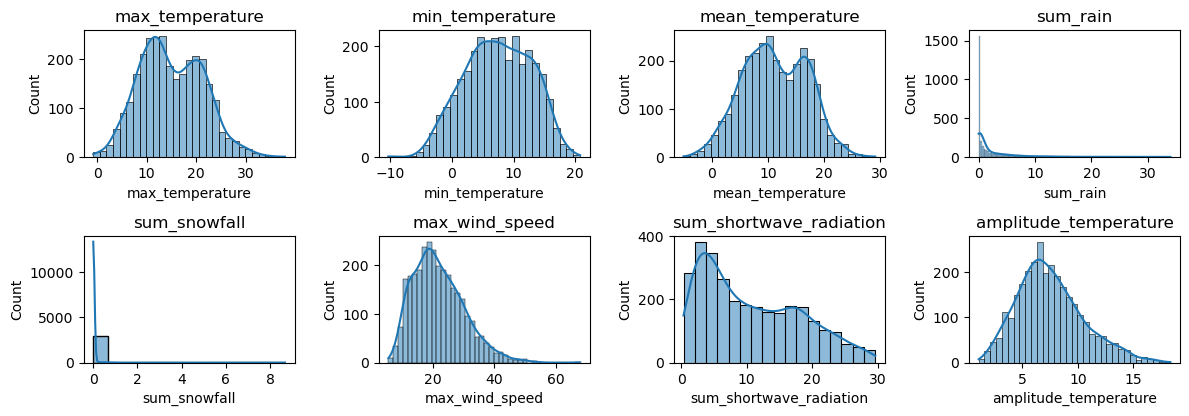

In [59]:
# проиллюстрируем распределение погодных признаков

plt.figure(figsize=(12, 10))

for i, col in enumerate(numeric_cols):
    plt.subplot(5, 4, i+1)
    sns.histplot(london_weather[col], kde=True)
    plt.title(col)
    
plt.tight_layout()
plt.show()

Видим походящие на нормальные распределения температур, что логично ввиду их постоянного измерения и постепенного изменения, а также наблюдаем, что снега и дождя в среднем выпадает мало. Ветер, тем не менее, стабильно высокие показатели имеет.

Посмотрим на корреляции погодных признаков:

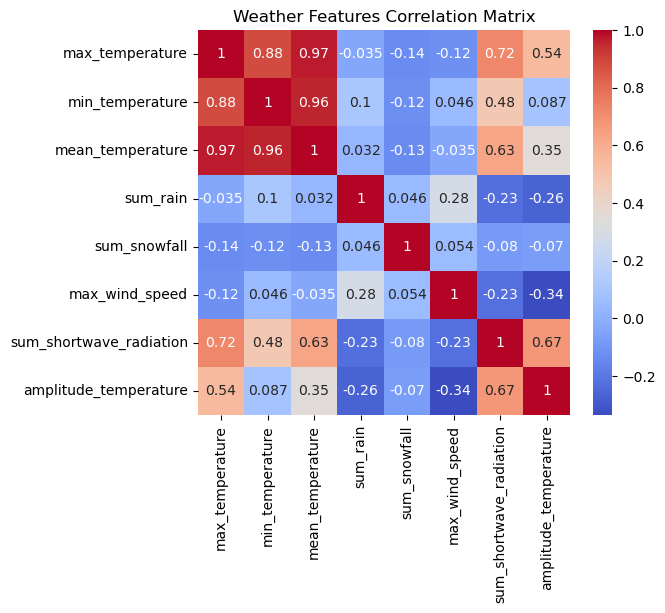

In [60]:
# weather correlation map

numeric_data = london_weather[numeric_cols]
corr_matrix = numeric_data.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Weather Features Correlation Matrix')
plt.show()

Очевидно, показатели максимальной/минимальной/средней температуры сильно коррелируют, так как измеряются в один и тот же день.
Более интересно посмотреть, что, по естественному предположению, солнечное излучение и температура положительно коррелируют, и дождь и снег с температурой коррелируют отрицательно. Интересно, что чем выше амплитуда температур, тем вероятнее выше была скорость ветра и больше выпало дождя! И дождь, конечно, часто приходит с ветром.

In [738]:
london_weather

date  weather_code  max_temperature  \
0    2015-12-31 23:00:00+00:00          51.0         7.800000   
1    2016-01-01 23:00:00+00:00          55.0        10.050000   
2    2016-01-02 23:00:00+00:00          63.0         9.500000   
3    2016-01-03 23:00:00+00:00          51.0         9.300000   
4    2016-01-04 23:00:00+00:00          53.0         9.450000   
...                        ...           ...              ...   
2978 2024-02-25 23:00:00+00:00          53.0         8.606501   
2979 2024-02-26 23:00:00+00:00          53.0         7.556500   
2980 2024-02-27 23:00:00+00:00          51.0        10.806500   
2981 2024-02-28 23:00:00+00:00          61.0        10.856501   
2982 2024-02-29 23:00:00+00:00          71.0         8.356501   

      min_temperature  mean_temperature   sum_rain  sum_snowfall  \
0             -0.4000          4.518750   1.100000          0.00   
1              7.5500          9.185416   5.699999          0.00   
2              5.5000          7.670833  11.300001          0.00   
3              5.3000          6.862500   0.900000          0.00   
4              3.5500          6.847918   0.700000          0.00   
...               ...               ...        ...           ...   
2978           3.3565          6.208583   1.400000          0.00   
2979           1.8065          4.637750   0.500000          0.00   
2980           5.5065          8.379416   1.300000          0.00   
2981           5.9065          9.316916   8.300000          0.00   
2982           3.1565          5.210667   6.500000          0.07   

      max_wind_speed  sum_shortwave_radiation  amplitude_temperature  
0          25.864943                     2.13               8.200000  
1          28.165257                     0.63               2.500000  
2          31.106167                     0.47               4.000000  
3          17.068707                     2.81               4.000000  
4          19.083395                     2.92               5.900000  
...              ...                      ...                    ...  
2978       43.672913                     7.12               5.250001  
2979       15.038350                     5.19               5.750000  
2980       25.071098                     3.53               5.300001  
2981       26.099379                     2.04               4.950001  
2982       34.942265                     8.22               5.200001  

[2983 rows x 10 columns]

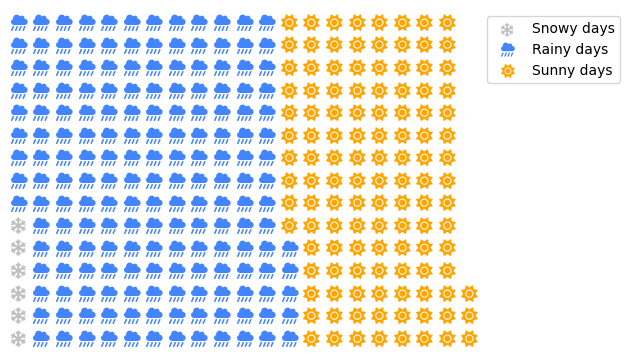

In [61]:
# проиллюстрируем распределение дождливых, снежных и солнечных дней
# при помощи эмодзи <3

# в классы погоды выделяем количество дней, когда дождевые осадки были равны нулю и больше нуля, также дни, когда наличествовал снег
# нормируем на 10 (иначе график будет разъезжаться)

weather_classes = {'Snowy days': london_weather['sum_snowfall'].loc[london_weather['sum_snowfall'] > 0 ].count()//10,
                   'Rainy days': london_weather['sum_rain'].loc[london_weather['sum_rain'] > 0 ].count()//10,
                   'Sunny days': london_weather['sum_rain'].loc[london_weather['sum_rain'] == 0 ].count()//10}
fig = plt.figure(
    FigureClass=Waffle,
    rows=15,
    values=weather_classes,
    colors=["#C0C0C0", "#4384FF", "#FFA500"],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['snowflake', 'cloud-showers-heavy', 'sun'],
    font_size=12,
    icon_legend=True
)
plt.show()

Видим, что большая часть дней в Лондоне - дождливые :(
Однако из предыдущего анализа и распределения признаков можно сделать вывод, что дождя обычно выпадает не много

Тем не менее, на этом можно построить предположение: влюди, будучи туристами Лондона, подготовлены к дождливой погоде или нестабильной температуре, так как знают, куда едут. Поэтому на их отпуск погода вряд ли повлияет. Это позволяет склонняться к тому, что нулевая гипотеза истинна

И так как погодные признаки это по сути своей временные ряды, то по ним мы можем выделить температурный тренд
Что само по себе интересно, поскольку это закладывает основу для анализа динамики глобального потепления, а также позволяет выявлять аномалии

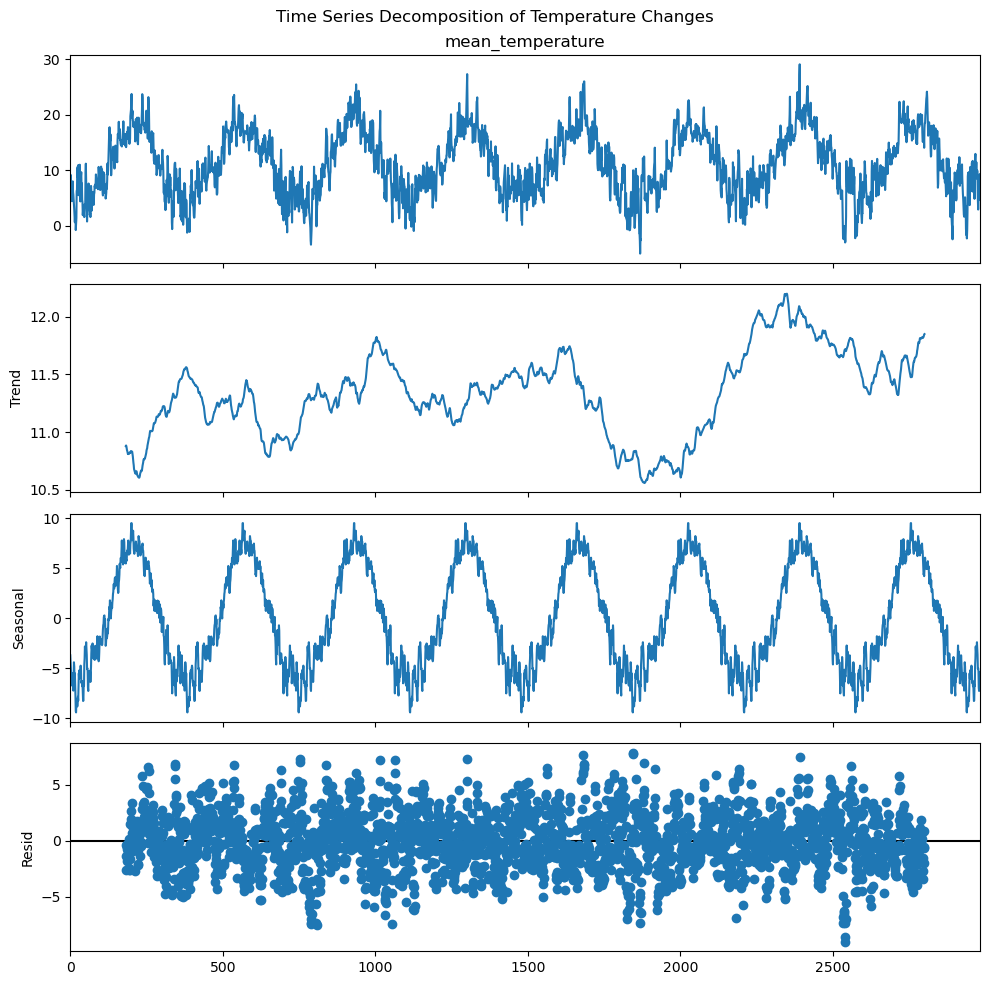

In [63]:
# очистим данные от цикличности, выделим тренд при помощи специальной библиотеки

decompose = seasonal_decompose(london_weather['mean_temperature'], period=365)

plt.rcParams.update({'figure.figsize': (10,10)})
decompose.plot().suptitle('Time Series Decomposition of Temperature Changes')
plt.tight_layout()
plt.show()

В итоге видим очень четкую сезонность (созданную естественным путем), равномерные остатки, а также выделяющиеся аномалии - например, неестественно холодный 2022 год! К слову, некоторые следы глобального потепления здесь тоже можно увидеть: пусть промежуток взят всего за 8 лет, с течением времени пики тренда поднимаются все выше и выше, увеличивая потенциально достижимые температуры

Теперь перейдем к анализу датафрейма с ревью. Сосредоточимся так же на Лондоне

In [ ]:
# EDA текстовые данные 

Пустые значения есть только в графе "компания", потому как некоторые люди не указывают, с какой целью и с кем они путешествуют. Незаполненных строк достаточно много, почти половина, поэтому не будем использовать этот признак для предсказания рейтинга

In [64]:
merged_sights.isnull().sum()

date        0
rating      0
title       0
review      0
name        0
crew      415
dtype: int64

/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_11937/1739888497.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pie_chart_data = [merged_sights.loc[merged_sights['rating'] == 5].count()[0],
/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_11937/1739888497.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_sights.loc[merged_sights['rating'] == 4].count()[0],
/var/folders/6v/s1fs_26158db7chz49zh63hc0000gn/T/ipykernel_11937/1739888497.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

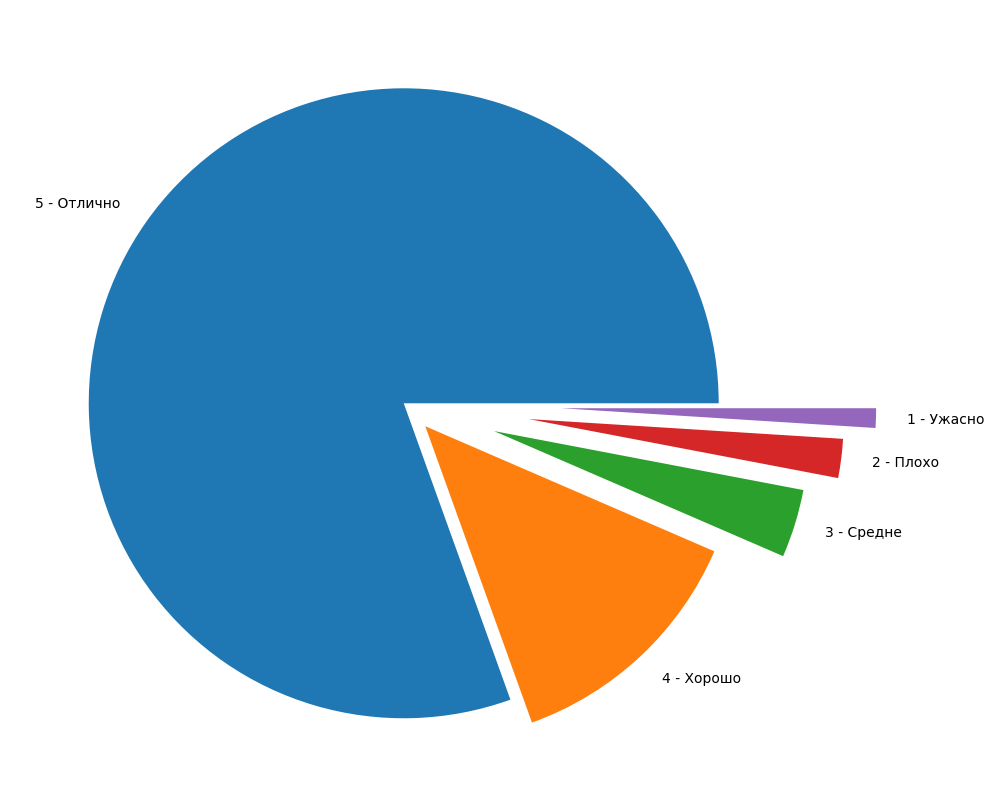

In [318]:
# посмотрим на распределение рейтинга посещения достопримечательностей по пятибалльной шкале

pie_chart_data = [merged_sights.loc[merged_sights['rating'] == 5].count()[0],
              merged_sights.loc[merged_sights['rating'] == 4].count()[0],
              merged_sights.loc[merged_sights['rating'] == 3].count()[0],
              merged_sights.loc[merged_sights['rating'] == 2].count()[0],
              merged_sights.loc[merged_sights['rating'] == 1].count()[0]]

labels = ['5 - Отлично', '4 - Хорошо', '3 - Средне', '2 - Плохо', '1 - Ужасно']

explode = [0, 0.1, 0.3, 0.4, 0.5]

plt.pie(pie_chart_data, labels=labels, explode=explode)
plt.tight_layout()
plt.show()

Итак, видим, что люди очень часто ставят 5 баллов, больше, чем в 75% случаев, а низкие оценки ставят крайне редко)
Благодаря этому наблюдению можно опять же склоняться к тому, что нулевая гипотеза истинна. Возможно, люди оценивают свои впечатления именно по месту, где они были, а на погоду не обращают внимания, считая ее нерелевантной, возможно, считают, что раз уж они в путешествии, это уже радость, и не стоит позволять погоде портить себе настроение. Можно выдвинуть множество альтернативных гипотез, однако для начала, нам нужно проверить нашу!

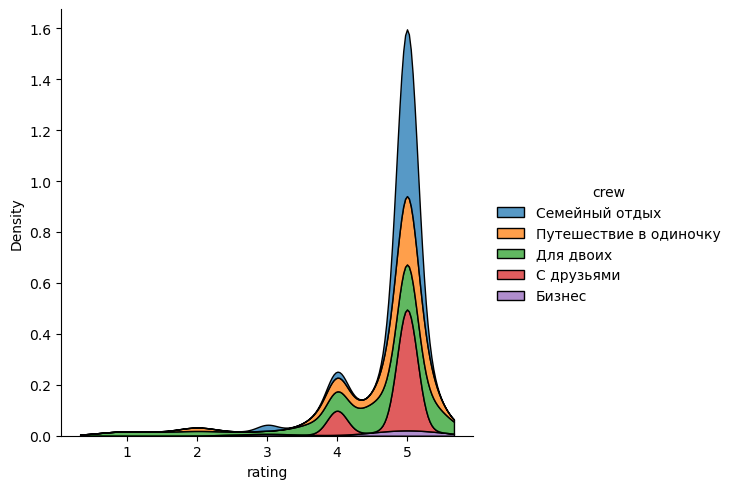

In [87]:
# посмотрим распределение рейтинга в зависимости от компании, с которой люди путешествуют

merged_sights['rating'] = pd.to_numeric(merged_sights['rating'])

sns.displot(merged_sights, x="rating", hue="crew", kind="kde", multiple="stack")

Путешествуя с семьей, люди чаще всего ставят 5 звезд :) 
Видимо, компания действительно улучшает опыт путешествия! Однако, это гипотеза уже для следующего исследования)

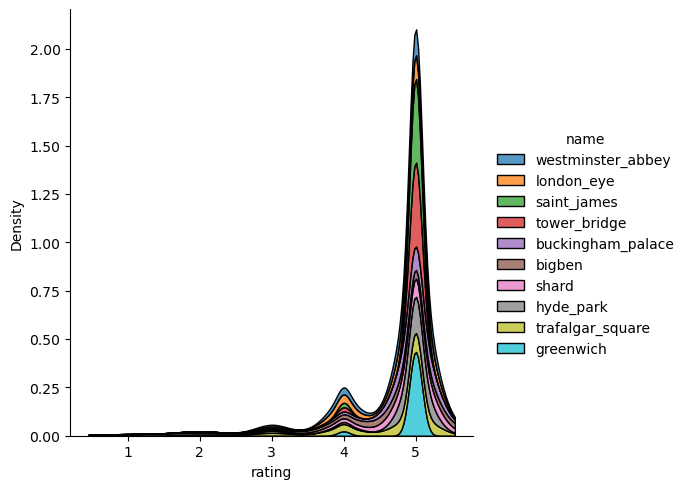

In [88]:
# посмотрим распределение рейтинга по достопримечательностям
# оно малопонятное, на самом деле

sns.displot(merged_sights, x="rating", hue="name", kind="kde", multiple="stack")

Теперь перейдем к самому интересному - текстам отзывов. Мое предположение состоит в том, что там мы все-таки сможем найти упоминания погоды, то есть влияние условий, температуры или дождя пусть и незначительно, но будет отражаться!

Но для начала посмотрим немного NLP статистики

In [319]:
def word_count(review):

    """
    Функция принимает на вход строку с текстом, возращает количество слов в тексте
    """
    
    review_list = review.split()
    return len(review_list)

In [320]:
info_df = pd.DataFrame()
info_df['title_word_count'] = merged_sights['title'].apply(word_count)
info_df['review_word_count'] = merged_sights['review'].apply(word_count)

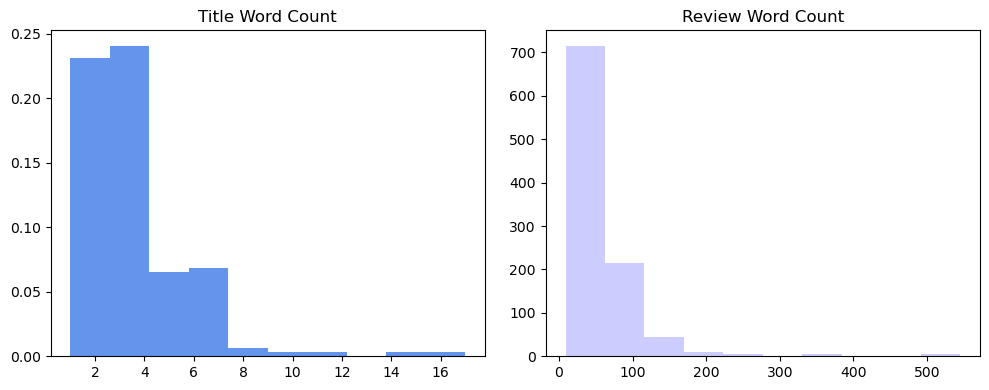

In [95]:
# Проиллюстрируем найденные показатели

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

ax0.hist(info_df['title_word_count'], density=True, histtype='bar', color='#6495ED')
ax0.set_title('Title Word Count')

ax1.hist(info_df['review_word_count'], histtype='bar', color='#CCCCFF' )
ax1.set_title('Review Word Count')


fig.tight_layout()
plt.show()

В основном отзывы короткие, какие-то выбросы вроде 500 слов на отзыв крайне редки. Но от них избавляться мы не будем, потому что там могут найтись заветные упоминания погоды!

In [96]:
info_df

title_word_count  review_word_count
0                   6                 31
1                   6                 31
2                   6                 31
3                   6                 31
4                   6                 31
..                ...                ...
995                 1                 22
996                 1                 22
997                 1                 22
998                 1                 22
999                 1                 22

[1000 rows x 2 columns]

In [97]:
print("Минимальное число слов в названии: ", min(info_df['title_word_count']))
print("Максимальное число слов в названии: ", max(info_df['title_word_count']))
print("Среднее число слов в названии: ", np.ceil(np.mean(info_df['title_word_count'])))

Минимальное число слов в названии:  1
Максимальное число слов в названии:  17
Среднее число слов в названии:  4.0


In [98]:
print("Минимальное число слов в отзыве: ", min(info_df['review_word_count']))
print("Максимальное число слов в отзыве: ", max(info_df['review_word_count']))
print("Среднее число слов в отзыве: ", np.ceil(np.mean(info_df['review_word_count'])))

Минимальное число слов в отзыве:  9
Максимальное число слов в отзыве:  545
Среднее число слов в отзыве:  55.0


Теперь перейдем к анализу содержания

In [156]:
# приведем тексты к нижнему регистру, очистим от пунктуации и лишних знаков, все в лучших традициях NLP EDA
# ! Использование регулярных выражений 

def clean_text(text):

    """
    Функция очищает отзыв от лишних знаков, пунктации, приводит слова в нижний регистр и токенизирует их
    """
     
    text = text.lower()
    text = re.sub('[^а-я А-Я 0-9]+', '', text)
    
    return text

In [147]:
# используем pymorphy, чтобы привести слова к начальной форме

morph = pymorphy2.MorphAnalyzer()

In [157]:
# предобработка: очистка текста, токенизация, удаление стоп-слов, приведение к начальной форме (лемматизация)
info_df['review'] = merged_sights['review'].apply(clean_text) 
info_df['review'] = info_df['review'].apply(lambda s: nltk.word_tokenize(s))
info_df['review'] = info_df['review'].apply(lambda str: [w for w in str if w not in stopwords])
info_df['review'] = info_df['review'].apply(lambda str: [morph.parse(w)[0].normal_form for w in str])

In [158]:
# чтобы проанализировать частотность, создадим общий список всех слов всех отзывов

review_corpus = list(info_df['review'])

In [159]:
reviews_merged = []
for word_list in review_corpus:
    reviews_merged += word_list

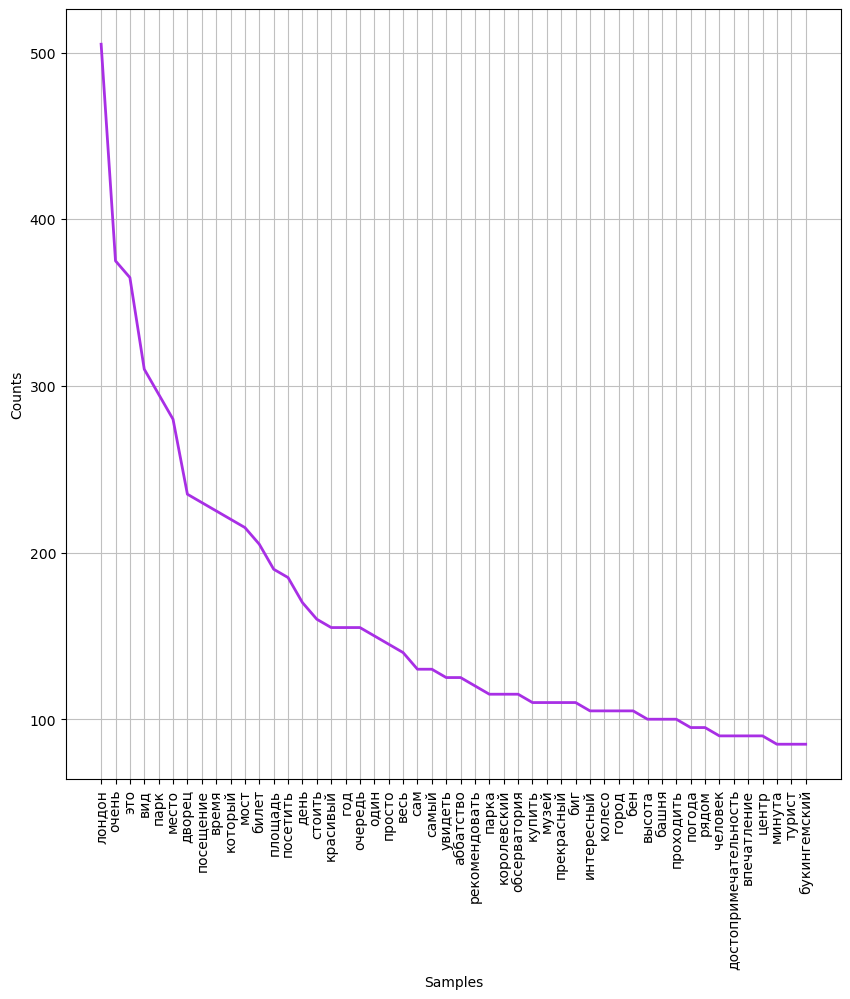

<Axes: xlabel='Samples', ylabel='Counts'>

In [160]:
fdist = FreqDist(reviews_merged)
fdist.plot(50, cumulative=False, color = '#A82FE5')

Видим, что погода все же встречается в топ-50 слов! Правда, не так часто, как вещи, более относящиеся к содержанию)
Посмотрим, даст ли анализ словосочетаний больше понимания, о какой погоде идет речь. Может быть, люди хвалят хорошую погоду?
Нарисуем облако слов

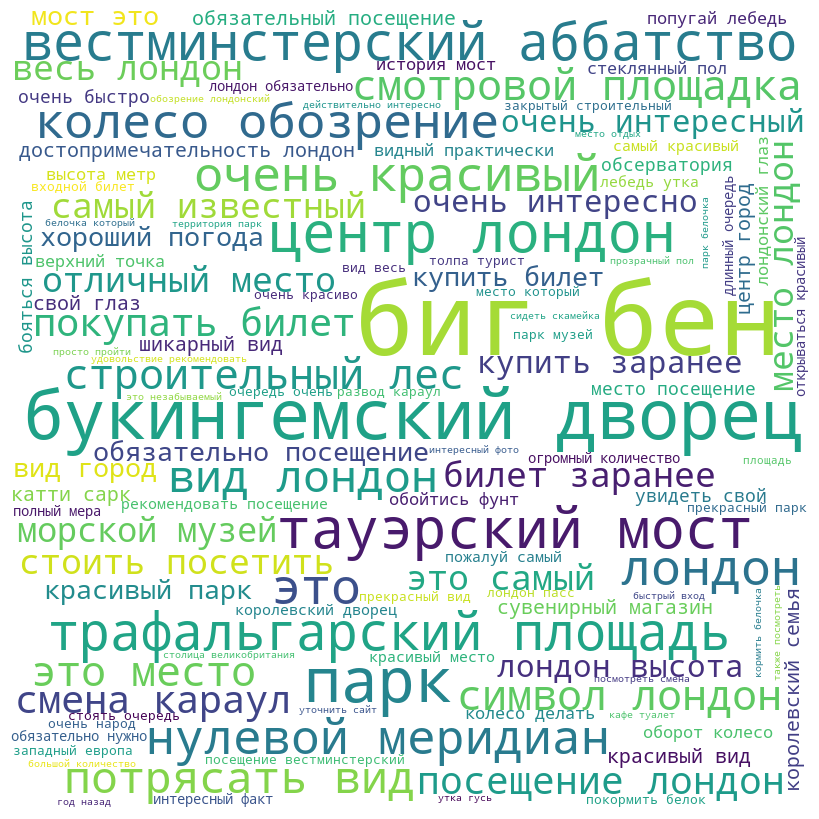

In [173]:
wc_reviews_merged = " ".join(reviews_merged)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(wc_reviews_merged)
                   
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Так и есть, хвалебные характеристики погоды встречаются, а вот плохих что-то не видно. Видимо, люди действительно склонны сосредотачиваться на хорошем, это видно по тому, как отзывы изобилуют положительными эпитетами и восхищением.

Может быть, упоминается что-то, что подразумевает погоду, но не указывает на нее явно? Например, уровень темноты или света, необходимость надевать теплую одежду, вид на пасмурное небо... Я не оставляю надежды и хочу посмотреть на кластеры словных эмбеддингов! Для этого используем графы и модель Navec 

In [ ]:
# ! используется networkx

In [221]:
# чтобы эта часть работала у вас, вам нужно будет скачать предобученную модель для русских словных эмбеддингов)
# файл в репозитории, весит он немного, всего 25 МБ

path = '/Users/alina/Downloads/navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [258]:
# беру 100 самых популярных слов из анализа частотности и создаю список эмбеддингов для них

keys = dict(fdist)
keys_sorted = {k: v for k, v in sorted(keys.items(), key=lambda item: item[1], reverse=True)}
words = list(keys_sorted.keys())
corpus = []
for word in words[:100]:
    try:
        corpus.append(navec[word])
    except:
        pass
    

In [260]:
# эмбеддинги имеют размерность 300, поэтому в целях иллюстрации нам надо ее сократить до 2)
# используем pca 

pca = PCA(n_components = 2)
pca_data = pca.fit_transform(np.array(corpus))

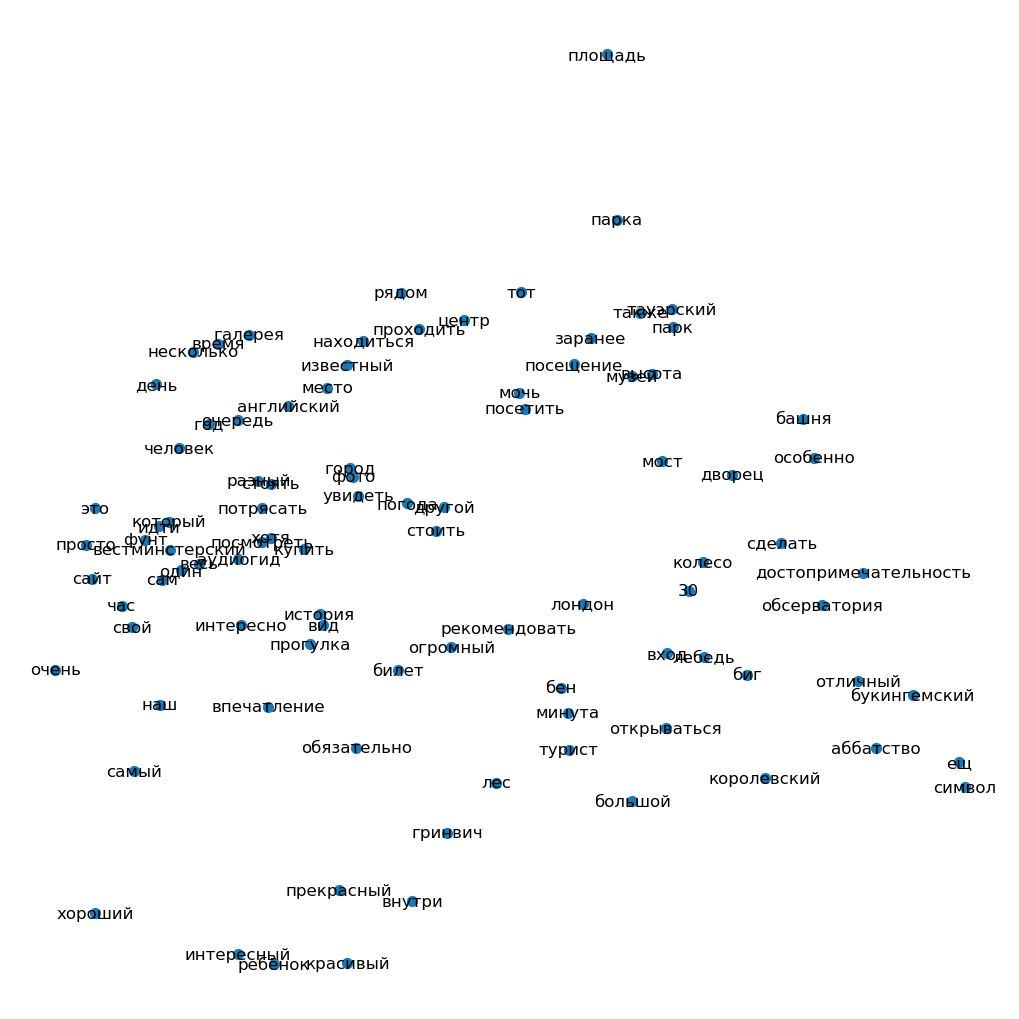

In [262]:
# иллюстрируем
 
G = nx.Graph()

for i in range(100):
    try:
        G.add_node(words[i], pos=pca_data[i])
    except:
        pass

nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=50)

Конечно, что-то про вид тут явно есть, но никаких намеков на погоду, тепло или холод в кластерах. Ну, в любом случае, мы получили очень много информации для формирования дальнейших гипотез! А теперь давайте численно проверим, влияет ли все-таки погода на опыт путешественников или нет

Будем предсказывать рейтинг отзыва по погодным признакам

## 4. Проверка гипотез при помощи ML: Linear Regression, Decision Tree

In [ ]:
# ! используется ML
# ! испольузется numpy для математического моделирования метрик

Для начала, попробуем подойти к оценке рейтинга как к задаче регрессии

In [269]:
cols = list(sights_weather.columns)

In [291]:
X_train, X_test, y_train, y_test = train_test_split(sights_weather[cols[3:]], sights_weather['rating'], stratify = sights_weather['rating'], test_size = 0.25) 
regr = LinearRegression() 
  
regr.fit(X_train, y_train) 
mse_regr = mean_squared_error(regr.predict(X_test), y_test)

In [292]:
target_range = np.max(y_test) - np.min(y_test)
percentage_accuracy_regr = (1.0 - (mse_regr / target_range)) * 100

In [293]:
percentage_accuracy_regr

87.892833717682

Казалось бы, процент правильных предсказаний очень большой, и можно было бы смело говорить, что нулевая гипотеза неверна. Однако что-то подсказывает, что здесь большую роль играет дисбаланс в данных (тот факт, что люди очень часто ставят 5 звезд). Попробуем подойти к задаче как к классификации

In [278]:
# смотрим на коэффициенты регресии - видим, что модель неадекватно выкрутила температуру, а остальное считается неважным
# такие абсурдные коэффициенты подсказывают, что все же это пустое угадывание, а не предсказание

coefficients_regr = pd.concat([pd.DataFrame(cols[3:]),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients_regr

0              0
0          max_temperature  193534.095505
1          min_temperature -193533.989802
2         mean_temperature      -0.090426
3                 sum_rain      -0.028191
4             sum_snowfall      -0.991355
5  sum_shortwave_radiation       0.001305
6    amplitude_temperature -193534.093862
7   mutability_temperature       0.144910

In [ ]:
Классификация с решающими деревьями

In [301]:
dt_class = DecisionTreeClassifier()
dt_class.fit(X_train, y_train)
f1 = f1_score(y_test, dt_class.predict(X_test), average='macro', labels=np.unique(dt_class.predict(X_test)))

In [302]:
f1

0.49004174727624483

Видим уже истинный ответ на наш вопрос - в задаче классификации, где мы учитываем дисбаланс классов при помощи метрики и стратифай, наш классификатор показывает 50%  - то есть это абсолютно случайная зависимость, где никакой возможности предсказать рейтинг нет

Таким образом, наша нулевая гипотеза верна!

In [313]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(merged_beaches[cols[3:]], merged_beaches['rating'], stratify = merged_beaches['rating'], test_size = 0.25) 

In [314]:
dt_class_b = DecisionTreeClassifier()
dt_class_b.fit(X_train_b, y_train_b)
f1_b = f1_score(y_test_b, dt_class_b.predict(X_test_b), average='macro', labels=np.unique(dt_class_b.predict(X_test_b)))

In [315]:
f1_b

0.6310924369747899

Сравнивая с пляжами, видим, что здесь уже результат немножко лучше, чем рандомный классификатор для Лондона.
Возможно, в случае с пляжным отдыхом, погода все же играет незначительную, но все же роль... Однако это тема уже для следующего исследования!